In [1]:
import tensorflow as tf

from distill.common.hparams import TransformerHparam, LSTMHparam
import os

from distill.data_util.prep_algorithmic import AlgorithmicIdentityDecimal40, AlgorithmicIdentityBinary40, \
  AlgorithmicAdditionDecimal40, AlgorithmicMultiplicationDecimal40, AlgorithmicSortProblem, AlgorithmicReverseProblem
from distill.data_util.prep_arithmatic import Arithmatic, ArithmaticSameLength, ArithmaticSimple, ArithmaticSimpleCurriculumLength,\
ArithmaticSimpleSameLength10, ArithmaticSimpleSameLength10Depth6, ArithmaticSimpleSameLength10Depth2, \
  ArithmaticSimpleSameLength10Depth4, \
  ArithmaticSimpleSameLength21Depth2Normal, ArithmaticSimpleSameLength201Depth2Normal, ArithmaticSimpleSameLength21Depth2NormalBiLing
from distill.data_util.prep_imdb import IMDB
from distill.data_util.prep_ptb import PTB
from distill.data_util.prep_sst import SST
from distill.data_util.prep_trec6 import CharTrec6, Trec6
from distill.data_util.prep_wsj_parsing import ParseWSJ
from distill.models.lm_lstm import LmLSTM
from distill.models.lstm_seq2seq import LSTMSeq2Seq, BidiLSTMSeq2Seq
from distill.models.transformer import Transformer, UniversalTransformer, EncodingTransformer, \
  EncodingUniversalTransformer, DecodingUniversalTransformer, DecodingTransformer
from distill.pipelines.distill_pipelines import Seq2SeqParallel
from distill.pipelines.seq2seq import Seq2SeqTrainer

from distill.common.distill_util import *

from sklearn.decomposition import PCA
import pandas as pd
from sklearn import manifold
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline  

def plot_embeddings(M_reduced, word2Ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        Include a label next to each point.
    """
    for word in words:
        x, y = M_reduced[word2Ind[word]]
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x+.01, y+.01, word, fontsize=10)
    plt.show()

def plot_embedding_components(emb_w):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(emb_w.numpy())
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    tsne_emb = tsne.fit_transform(emb_w.numpy())

    M_reduced_plot_test = principalComponents
    word2Ind_plot_test = student_model.task.word2id
    words = student_model.task.id2word
    plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)

    M_reduced_plot_test = tsne_emb
    word2Ind_plot_test = student_model.task.word2id
    words = student_model.task.id2word
    plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)
    

# Enable TF Eager execution
tfe = tf.contrib.eager
tfe.enable_eager_execution()

# Other setup
Modes = tf.estimator.ModeKeys

In [2]:
tf.app.flags.DEFINE_string("exp_name", "distill", "")
tf.app.flags.DEFINE_string("task_name", "identity_binary", "")
tf.app.flags.DEFINE_string("log_dir", "logs", "")
tf.app.flags.DEFINE_string("data_dir", "../data", "")

tf.app.flags.DEFINE_string("save_dir", None, "")

tf.app.flags.DEFINE_string("model_type", "lstm2transformer", "")
tf.app.flags.DEFINE_string("teacher_model", "enc_utransformer", "")
tf.app.flags.DEFINE_string("student_model", "enc_utransformer", "")

tf.app.flags.DEFINE_boolean("train_teacher", True, "")
tf.app.flags.DEFINE_boolean("train_student", True, "")
tf.app.flags.DEFINE_boolean("distill_rep", False, "")
tf.app.flags.DEFINE_boolean("distill_logit", True, "")

tf.app.flags.DEFINE_boolean("pretrain_teacher", True, "")
tf.app.flags.DEFINE_integer("teacher_pretraining_iters", 100, "")
tf.app.flags.DEFINE_string("rep_loss_mode", 'dot_product', "representation loss type (squared,softmax_cross_ent,sigmoid_cross_ent")

tf.app.flags.DEFINE_string("model", "enc_utransformer", "transformer | utransformer | lstm | bilstm")
tf.app.flags.DEFINE_string("teacher_encoder_attention_dir", "top_down", "top_down | bottom_up")
tf.app.flags.DEFINE_string("student_encoder_attention_dir", "top_down", "top_down | bottom_up")


tf.app.flags.DEFINE_integer("teacher_hidden_dim", 256, "")
tf.app.flags.DEFINE_integer("teacher_encoder_depth", 4, "")
tf.app.flags.DEFINE_integer("teacher_decoder_depth", 1, "")
tf.app.flags.DEFINE_integer("student_hidden_dim", 128, "")
tf.app.flags.DEFINE_integer("student_encoder_depth", 4, "")
tf.app.flags.DEFINE_integer("student_decoder_depth", 1, "")

tf.app.flags.DEFINE_integer("input_dim", None, "")
tf.app.flags.DEFINE_integer("output_dim", 1, "")
tf.app.flags.DEFINE_integer("number_of_heads", 4, "")
tf.app.flags.DEFINE_integer("ff_filter_size", 512, "")
tf.app.flags.DEFINE_float("initializer_gain", 1.0, "")
tf.app.flags.DEFINE_float("teacher_label_smoothing", 0.0001, "")
tf.app.flags.DEFINE_float("student_label_smoothing", 0.0001, "")

tf.app.flags.DEFINE_boolean('teacher_train_embeddings', True, " False | True")
tf.app.flags.DEFINE_boolean('student_train_embeddings', True, " False | True")

tf.app.flags.DEFINE_string('teacher_sent_rep_mode', "all", "none | final | all")
tf.app.flags.DEFINE_string('student_sent_rep_mode', "all", "none | final | all")

tf.app.flags.DEFINE_string('teacher_attention_mechanism', None, 'attention_mechanism')
tf.app.flags.DEFINE_string('student_attention_mechanism', None, 'attention_mechanism')


tf.app.flags.DEFINE_float("teacher_input_dropout_keep_prob", 0.8, "")
tf.app.flags.DEFINE_float("teacher_hidden_dropout_keep_prob", 0.9, "")
tf.app.flags.DEFINE_float("student_input_dropout_keep_prob", 0.75, "")
tf.app.flags.DEFINE_float("student_hidden_dropout_keep_prob", 0.5, "")


tf.app.flags.DEFINE_float("teacher_learning_rate", 0.001, "")
tf.app.flags.DEFINE_float("student_learning_rate", 0.001, "")
tf.app.flags.DEFINE_float("distill_learning_rate", 0.001, "")
tf.app.flags.DEFINE_float("data_weight", 0.00, "")
tf.app.flags.DEFINE_float("distill_logits_weight", 1.00, "")
tf.app.flags.DEFINE_float("distill_rep_weight", 0.0, "")
tf.app.flags.DEFINE_float("teacher_rep_distill_weight", 0.0, "")
tf.app.flags.DEFINE_float("distill_temp", 1, "")
tf.app.flags.DEFINE_float("teacher_temp", 1, "")
tf.app.flags.DEFINE_float("student_temp", 1, "")
tf.app.flags.DEFINE_boolean("learn_to_teach", False, "")



tf.app.flags.DEFINE_boolean("decay_learning_rate", True, "True | False")
tf.app.flags.DEFINE_float("l2_rate", 0.0001, "")


tf.app.flags.DEFINE_integer("batch_size", 32, "")
tf.app.flags.DEFINE_integer("training_iterations", 300000, "")

tf.app.flags.DEFINE_integer("vocab_size", 3, "")
tf.app.flags.DEFINE_integer("embedding_dim", 256, "embeddings dim")

tf.app.flags.DEFINE_string("data_path", "../data", "data path")



tf.app.flags.DEFINE_string("f","","kernel")
hparams = tf.app.flags.FLAGS

In [3]:
Models = {"lstm": LSTMSeq2Seq,
        "bilstm": BidiLSTMSeq2Seq,
        "transformer": Transformer,
        "utransformer": UniversalTransformer,
        "enc_transformer": EncodingTransformer,
        "enc_utransformer": EncodingUniversalTransformer}


tasks = {'identity': AlgorithmicIdentityDecimal40(os.path.join(hparams.data_dir,'alg')),
       'identity_binary': AlgorithmicIdentityBinary40(os.path.join(hparams.data_dir,'alg')),
       'addition': AlgorithmicAdditionDecimal40(os.path.join(hparams.data_dir,'alg')),
       'multiplication': AlgorithmicMultiplicationDecimal40(os.path.join(hparams.data_dir,'alg')),
       'sort': AlgorithmicSortProblem(os.path.join(hparams.data_dir,'alg')),
       'reverse': AlgorithmicReverseProblem(os.path.join(hparams.data_dir,'alg')),
       'arithmatic': Arithmatic(os.path.join(hparams.data_dir,'arithmatic')),
       'arithmatic_simple': ArithmaticSimple(os.path.join(hparams.data_dir,'arithmatic_simple')),
       'arithmatic_samelength': ArithmaticSameLength(os.path.join(hparams.data_dir,'arithmatic_samelength')),
       'arithmatic_simple_curriculum_length': ArithmaticSimpleCurriculumLength(os.path.join(hparams.data_dir,'arithmatic_simple_curriculum_length')),
       'arithmatic_simple_samelength': ArithmaticSameLength(os.path.join(hparams.data_dir,'arithmatic_samelength')),
       'arithmatic_simple_samelength10': ArithmaticSimpleSameLength10(os.path.join(hparams.data_dir,'arithmatic_simple_samelength10')),
       'arithmatic_simple_samelength10_depth6': ArithmaticSimpleSameLength10Depth6(os.path.join(hparams.data_dir,'arithmatic_simple_samelength10_depth6')),
       'arithmatic_simple_samelength10_depth4': ArithmaticSimpleSameLength10Depth4(os.path.join(hparams.data_dir,'arithmatic_simple_samelength10_depth4')),
       'arithmatic_simple_samelength10_depth2': ArithmaticSimpleSameLength10Depth2(os.path.join(hparams.data_dir,'arithmatic_simple_samelength10_depth2')),
       'arithmatic_simple_samelength21_depth2_normal': ArithmaticSimpleSameLength21Depth2Normal(os.path.join(hparams.data_dir,'arithmatic_simple_samelength21_depth2_normal')),
       'arithmatic_simple_samelength21_depth2_normal_biling': ArithmaticSimpleSameLength21Depth2NormalBiLing(
         os.path.join(hparams.data_dir, 'arithmatic_simple_samelength21_depth2_normal_biling')),
       'arithmatic_simple_samelength201_depth2_normal': ArithmaticSimpleSameLength201Depth2Normal(
         os.path.join(hparams.data_dir, 'arithmatic_simple_samelength201_depth2_normal')),
       'sst': SST(data_path=os.path.join(hparams.data_dir,"sst/"),
             add_subtrees=False,
             pretrained=False),
       'ptb_lm': PTB(os.path.join(hparams.data_dir,'ptb')),
       'wsj_parse': ParseWSJ(os.path.join(hparams.data_dir,'wsj')),
       'imdb': IMDB(data_path=os.path.join(hparams.data_dir,"imdb"),
                    pretrained=True),
        'char_trec': CharTrec6(os.path.join(hparams.data_dir,"char_trec6"), build_vocab=False)
       }

4 total unique words
loading vocab from:  ../data/sst/vocab


In [4]:
hparams.task_name = 'arithmatic_simple_samelength21_depth2_normal_biling'
hparams.vocab_size = tasks[hparams.task_name].vocab_length
hparams.output_dim = len(tasks[hparams.task_name].target_vocab)
task = tasks[hparams.task_name]

Models = {"lstm": LSTMSeq2Seq,
            "bilstm": BidiLSTMSeq2Seq,
            "transformer": Transformer,
            "utransformer": UniversalTransformer,
            "enc_transformer": EncodingTransformer,
            "enc_utransformer": EncodingUniversalTransformer}

CLS_TOKEN = {"lstm": False,
          "bilstm": False,
          "transformer": False,
          "utransformer": False,
          "enc_transformer": True,
          "enc_utransformer": True}

hparams.vocab_size = tasks[hparams.task_name].vocab_length
hparams.output_dim = len(tasks[hparams.task_name].target_vocab)

print(hparams.vocab_size, hparams.output_dim)

PARAM_TYPES = {"lstm": LSTMHparam,
        "bilstm": LSTMHparam,
        "transformer": TransformerHparam,
        "utransformer": TransformerHparam,
        "enc_transformer": TransformerHparam,
        "enc_utransformer": TransformerHparam}

teacher_params = PARAM_TYPES[hparams.teacher_model](input_dim=hparams.input_dim,
                                                  output_dim=hparams.output_dim,
                                                  hidden_dim=hparams.teacher_hidden_dim,
                                                  encoder_depth=hparams.teacher_encoder_depth,
                                                  decoder_depth=hparams.teacher_decoder_depth,
                                                  number_of_heads=4,
                                                  ff_filter_size=hparams.teacher_hidden_dim*4,
                                                  initializer_gain=hparams.initializer_gain,
                                                  batch_size=hparams.batch_size,
                                                  input_dropout_keep_prob=hparams.teacher_input_dropout_keep_prob,
                                                  hidden_dropout_keep_prob=hparams.teacher_hidden_dropout_keep_prob,
                                                  vocab_size=hparams.vocab_size,
                                                  label_smoothing=hparams.teacher_label_smoothing,
                                                  encoder_self_attention_dir=hparams.teacher_encoder_attention_dir,
                                                  decoder_self_attention_dir="top_down",
                                                  decoder_cross_attention_dir="top_down",
                                                  train_embeddings=hparams.teacher_train_embeddings,
                                                  attention_mechanism=None,
                                                  sent_rep_mode=hparams.teacher_sent_rep_mode,
                                                  embedding_dim=hparams.teacher_hidden_dim,
                                                  learning_rate=hparams.teacher_learning_rate,
                                                  cls_token=CLS_TOKEN[hparams.teacher_model]
                                                  )

student_params = PARAM_TYPES[hparams.student_model](input_dim=hparams.input_dim,
                                                  output_dim=hparams.output_dim,
                                                  hidden_dim=hparams.student_hidden_dim,
                                                  encoder_depth=hparams.student_encoder_depth,
                                                  decoder_depth=hparams.student_decoder_depth,
                                                  number_of_heads=4,
                                                  ff_filter_size=hparams.student_hidden_dim*4,
                                                  initializer_gain=hparams.initializer_gain,
                                                  batch_size=hparams.batch_size,
                                                  input_dropout_keep_prob=hparams.student_input_dropout_keep_prob,
                                                  hidden_dropout_keep_prob=hparams.student_hidden_dropout_keep_prob,
                                                  vocab_size=hparams.vocab_size,
                                                  label_smoothing=hparams.student_label_smoothing,
                                                  encoder_self_attention_dir=hparams.student_encoder_attention_dir,
                                                  decoder_self_attention_dir="top_down",
                                                  decoder_cross_attention_dir="top_down",
                                                  train_embeddings=hparams.student_train_embeddings,
                                                  attention_mechanism=None,
                                                  sent_rep_mode=hparams.student_sent_rep_mode,
                                                  embedding_dim=hparams.student_hidden_dim,
                                                  learning_rate=hparams.student_learning_rate,
                                                  cls_token=CLS_TOKEN[hparams.student_model]
                                                  )

51 51


In [5]:
print(hparams.student_model)
student_model = Models[hparams.student_model](student_params,
                                task=tasks[hparams.task_name],
                                scope=hparams.student_model+"_student")

enc_utransformer


In [6]:
print(hparams.teacher_model)
teacher_model = Models[hparams.teacher_model](teacher_params,
                                task=tasks[hparams.task_name],
                                scope=hparams.teacher_model+"_teacher")

enc_utransformer


In [7]:
dataset = tf.data.TFRecordDataset(student_model.task.get_tfrecord_path(mode="train"))
dataset = dataset.map(student_model.task.parse_examples)
dataset = dataset.padded_batch(hparams.batch_size, padded_shapes=student_model.task.get_padded_shapes())
dataset = dataset.map((lambda x1,x2,x3,x4: ((x1,x2,x3,x4),(x1,x2,x3,x4))))
dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.repeat()
train_iterator = dataset.make_one_shot_iterator()

dataset = tf.data.TFRecordDataset(student_model.task.get_tfrecord_path(mode="dev"))
dataset = dataset.map(student_model.task.parse_examples)
dataset = dataset.padded_batch(hparams.batch_size, padded_shapes=student_model.task.get_padded_shapes())
dataset = dataset.map((lambda x1,x2,x3,x4: ((x1,x2,x3,x4),(x1,x2,x3,x4))))
dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.repeat()
dev_iterator = dataset.make_one_shot_iterator()

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
teacher_train_examples, student_train_examples = train_iterator.get_next()
teacher_dev_examples, student_dev_examples = dev_iterator.get_next()





In [9]:
i = np.random.randint(len(teacher_train_examples[0]))
print(i, len(teacher_train_examples[0]))
example_inputs, example_targets = list(zip(teacher_train_examples[0], teacher_train_examples[1]))[i]
print(' '.join(task.decode(example_inputs)).replace('<pad>',''))
#print(eval(' '.join(task.decode(example_inputs)).replace('<pad>','').replace('<eos>', '')))

print(task.decode((example_targets)))


print(' '.join(task.decode(example_inputs)).replace('<pad>',''))
#print(eval(' '.join(task.decode(example_inputs)).replace('<pad>','').replace('<eos>', '')))

print(example_targets)

26 32
( nine minus nine ) plus ( eight plus ( four plus seven ) minus two minus ( nine plus two ) ) plus ( five minus two ) minus six <eos>                          
['three']
( nine minus nine ) plus ( eight plus ( four plus seven ) minus two minus ( nine plus two ) ) plus ( five minus two ) minus six <eos>                          
tf.Tensor([39], shape=(1,), dtype=int64)


In [10]:
save_dir = "../logs/arithmatic_simple_samelength21_depth2_normal_biling/" + \
"dot_product_enc_utransformer_to_enc_utransformer_std_depth4_teacher_depth4_std_hidden_dim128_teacher_hidden_dim256_parallel_try17"
#"dot_product_lstm_to_lstm_std_depth1_teacher_depth1_std_hidden_dim128_teacher_hidden_dim128__parrallel_tdrop9-9_sdrop9-9_LR001_L20001"
#'dot_product_lstm_to_lstm_std_depth1_teacher_depth1_std_hidden_dim128_teacher_hidden_dim128__indp_drop075-08_drop075-08_L2_v5'

checkpoint = tf.train.latest_checkpoint(save_dir)
print(checkpoint)

../logs/arithmatic_simple_samelength21_depth2_normal_biling/dot_product_enc_utransformer_to_enc_utransformer_std_depth4_teacher_depth4_std_hidden_dim128_teacher_hidden_dim256_parallel_try17/model.ckpt-87638


In [11]:
variables_in_checkpoint = tf.train.list_variables(checkpoint)
print("Variables found in checkpoint file",variables_in_checkpoint)

Variables found in checkpoint file [('enc_utransformer_student/InputEmbed/embedding_and_softmax/weights', [51, 128]), ('enc_utransformer_student/UniversalTransformerEncoder/layer_norm_bias', [128]), ('enc_utransformer_student/UniversalTransformerEncoder/layer_norm_scale', [128]), ('enc_utransformer_student/encode/UniversalTransformerEncoder/FF/filter_layer/bias', [512]), ('enc_utransformer_student/encode/UniversalTransformerEncoder/FF/filter_layer/kernel', [128, 512]), ('enc_utransformer_student/encode/UniversalTransformerEncoder/FF/output_layer/bias', [128]), ('enc_utransformer_student/encode/UniversalTransformerEncoder/FF/output_layer/kernel', [512, 128]), ('enc_utransformer_student/encode/UniversalTransformerEncoder/k/kernel', [128, 128]), ('enc_utransformer_student/encode/UniversalTransformerEncoder/k_1/kernel', [128, 128]), ('enc_utransformer_student/encode/UniversalTransformerEncoder/k_2/kernel', [128, 128]), ('enc_utransformer_student/encode/UniversalTransformerEncoder/k_3/kerne

In [12]:
with tfe.restore_variables_on_create(checkpoint):
    teacher_model.create_vars(reuse=True)
    student_model.create_vars(reuse=True)

    train_output_dic = teacher_model.apply(teacher_train_examples, target_length=student_model.task.target_length, is_train=False)

INFO:tensorflow:inputs shape
INFO:tensorflow:tf.Tensor(
[[ 2 49 14 ...  0  0  0]
 [ 2 43 48 ...  0  0  0]
 [ 2 49 49 ...  0  0  0]
 ...
 [ 2 43 48 ...  0  0  0]
 [ 2 20 25 ...  0  0  0]
 [ 2 49 22 ...  0  0  0]], shape=(32, 59), dtype=int64)
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


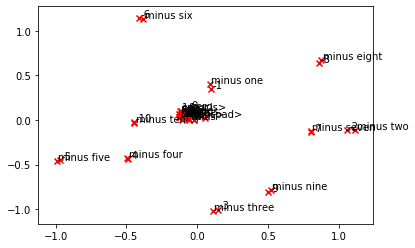

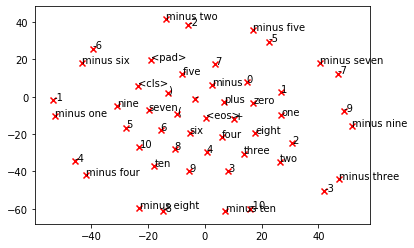

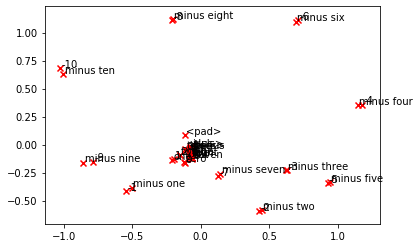

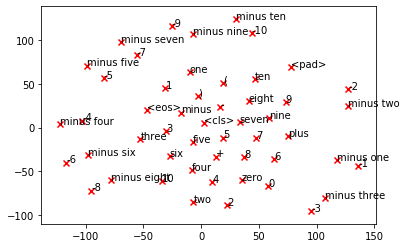

distance with general bias tf.Tensor(0.87287426, shape=(), dtype=float32)
distance with local bias tf.Tensor(0.07071161, shape=(), dtype=float32)
self distance with general bias tf.Tensor(0.0, shape=(), dtype=float32)
self distance with local bias tf.Tensor(0.0, shape=(), dtype=float32)


In [13]:
with tfe.restore_variables_on_create(checkpoint):
    teacher_emb_w = teacher_model.input_embedding_layer.shared_weights
    plot_embedding_components(teacher_emb_w)


    student_emb_w = student_model.input_embedding_layer.shared_weights
    plot_embedding_components(student_emb_w)

    distance_with_general_bias = get_biased_single_state_rsa_distill_loss(student_emb_w, teacher_emb_w, mode='dot_product', bias="general")
    distance_with_local_bias = get_biased_single_state_rsa_distill_loss(student_emb_w, teacher_emb_w, mode='dot_product', bias="local")
    self_distance_with_general_bias = get_biased_single_state_rsa_distill_loss(teacher_emb_w, teacher_emb_w, mode='dot_product', bias="general")
    self_distance_with_local_bias = get_biased_single_state_rsa_distill_loss(teacher_emb_w, teacher_emb_w, mode='dot_product', bias="local")

    print("distance with general bias", distance_with_general_bias)
    print("distance with local bias", distance_with_local_bias)

    print("self distance with general bias", self_distance_with_general_bias)
    print("self distance with local bias", self_distance_with_local_bias)

In [14]:
example_str =  '( 1 + 2 ) - ( 3 + 4 ) + ( 4 + 5 ) <eos>'
example_input = example_str.split()
example_target = str(eval(' '.join(example_input[:-1])))
encoded_example = tf.convert_to_tensor([teacher_model.task.encode(example_input)], dtype=tf.int64)
encoded_target = tf.convert_to_tensor([teacher_model.task.encode(example_target)], dtype=tf.int64)

example = (encoded_example, encoded_target, tf.convert_to_tensor([len(example_input)], dtype=tf.int64), tf.convert_to_tensor([1], dtype=tf.int64))
print(example)
weights_dic = {}
with tfe.restore_variables_on_create(checkpoint):
    teach_outputs = teacher_model.apply(example, \
                                                     target_length=teacher_model.task.target_length, is_train=False, dic_to_save_weights=weights_dic)

print(' '.join(student_model.task.decode(example[0][0])))
print(np.argmax(teach_outputs['logits'], axis=-1).shape)
print(student_model.task.decode(np.argmax(teach_outputs['logits'], axis=-1)[0]))

(<tf.Tensor: id=3362, shape=(1, 18), dtype=int64, numpy=
array([[49, 14, 24, 15, 50, 25, 49, 16, 24, 17, 50, 24, 49, 17, 24, 18,
        50,  1]])>, <tf.Tensor: id=3363, shape=(1, 1), dtype=int64, numpy=array([[18]])>, <tf.Tensor: id=3364, shape=(1,), dtype=int64, numpy=array([18])>, <tf.Tensor: id=3365, shape=(1,), dtype=int64, numpy=array([1])>)
INFO:tensorflow:inputs shape
INFO:tensorflow:tf.Tensor([[ 2 49 14 24 15 50 25 49 16 24 17 50 24 49 17 24 18 50  1]], shape=(1, 19), dtype=int64)
( 1 + 2 ) - ( 3 + 4 ) + ( 4 + 5 ) <eos>
(1, 1)
['minus three']


In [15]:
!pip install seaborn

enc_utransformer_teacher/encode/UniversalTransformerEncoder/attention/_0_attention_logits
(1, 4, 19, 19)


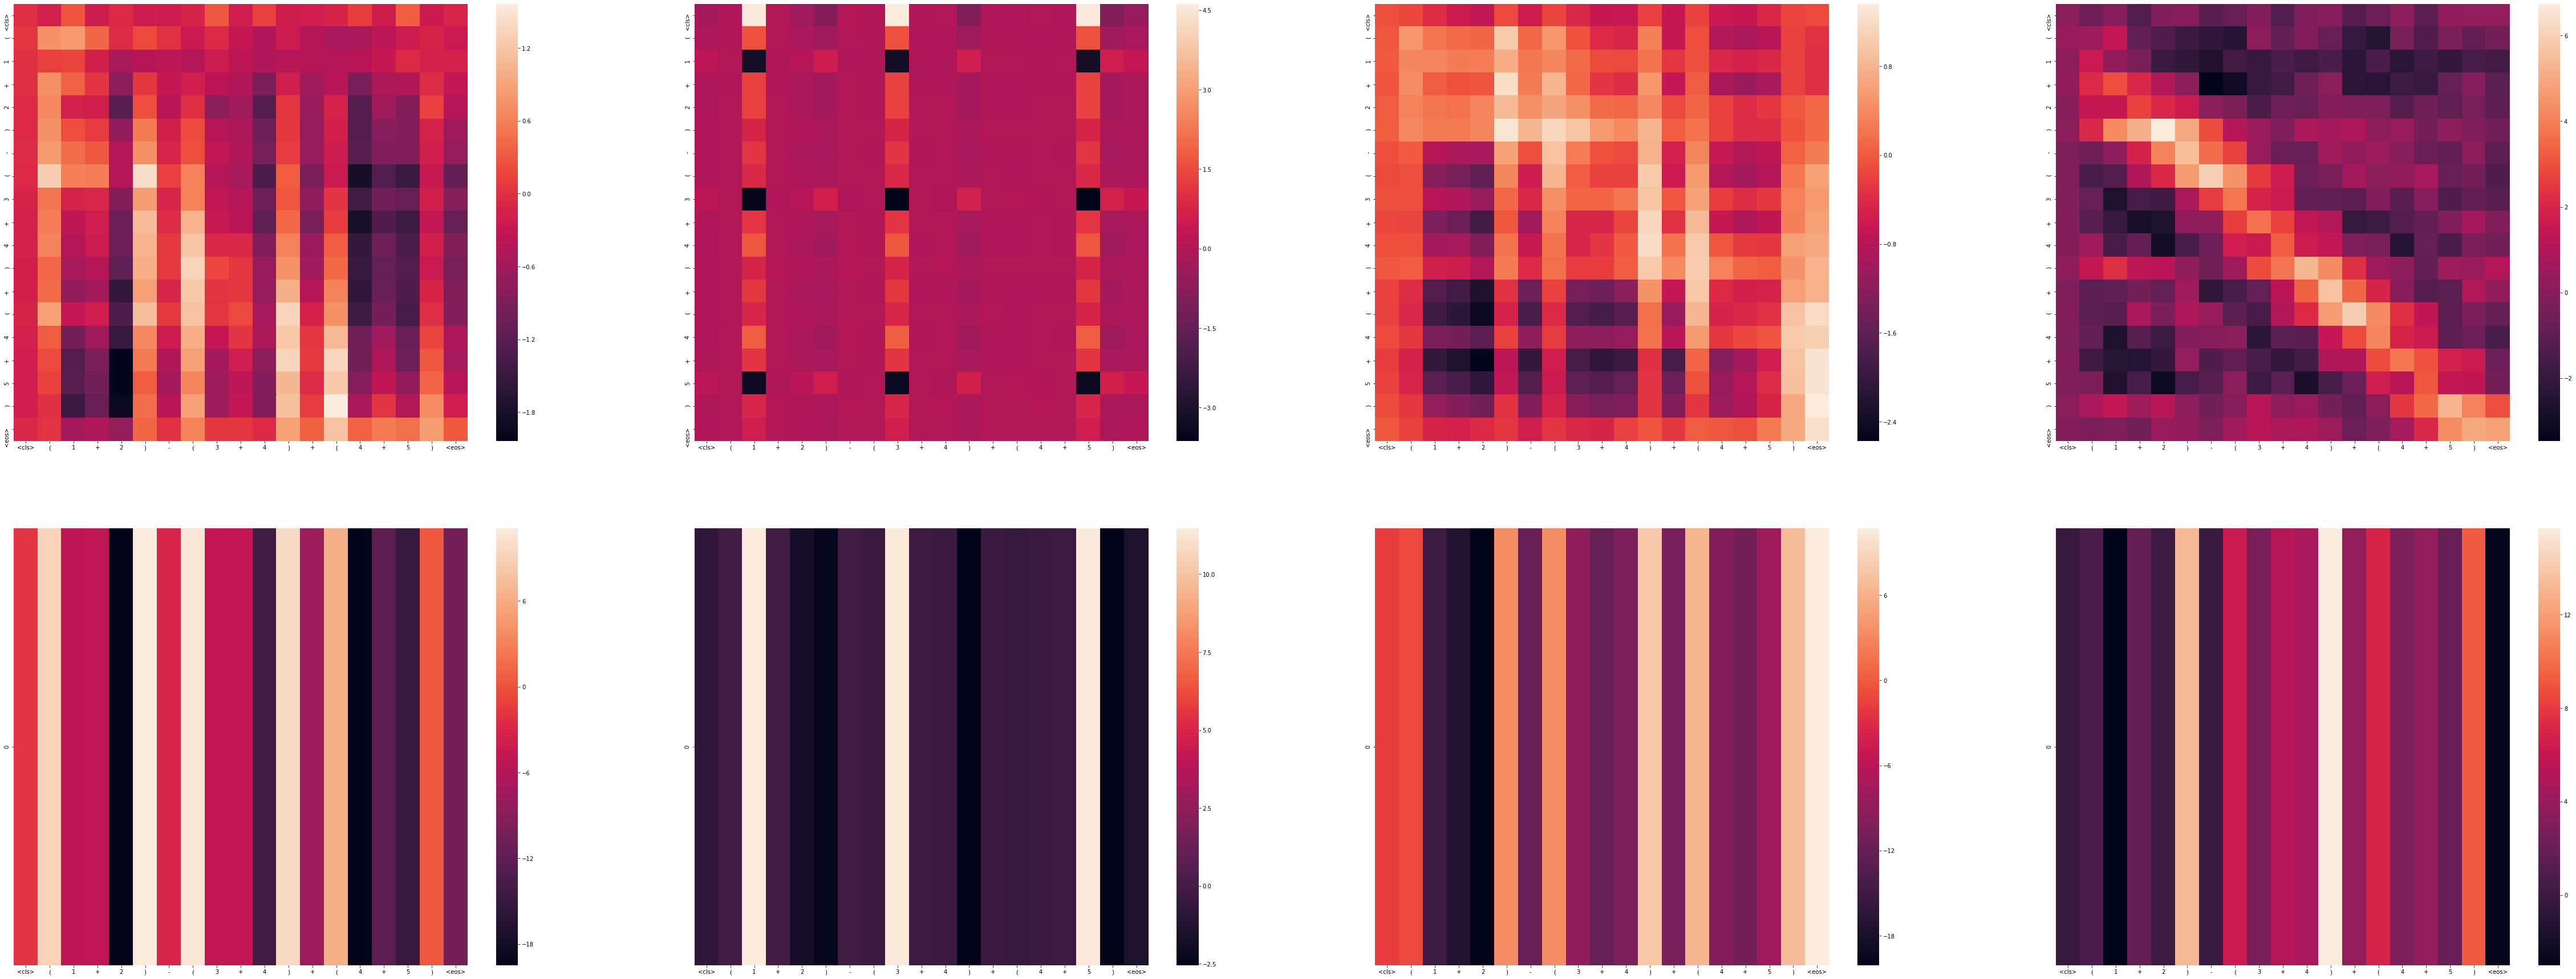

enc_utransformer_teacher/encode/UniversalTransformerEncoder/attention/_0_attention_bias
(1, 1, 1, 19)


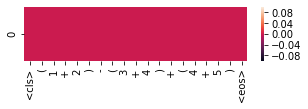

enc_utransformer_teacher/encode/UniversalTransformerEncoder/attention/_1_attention_logits
(1, 4, 19, 19)


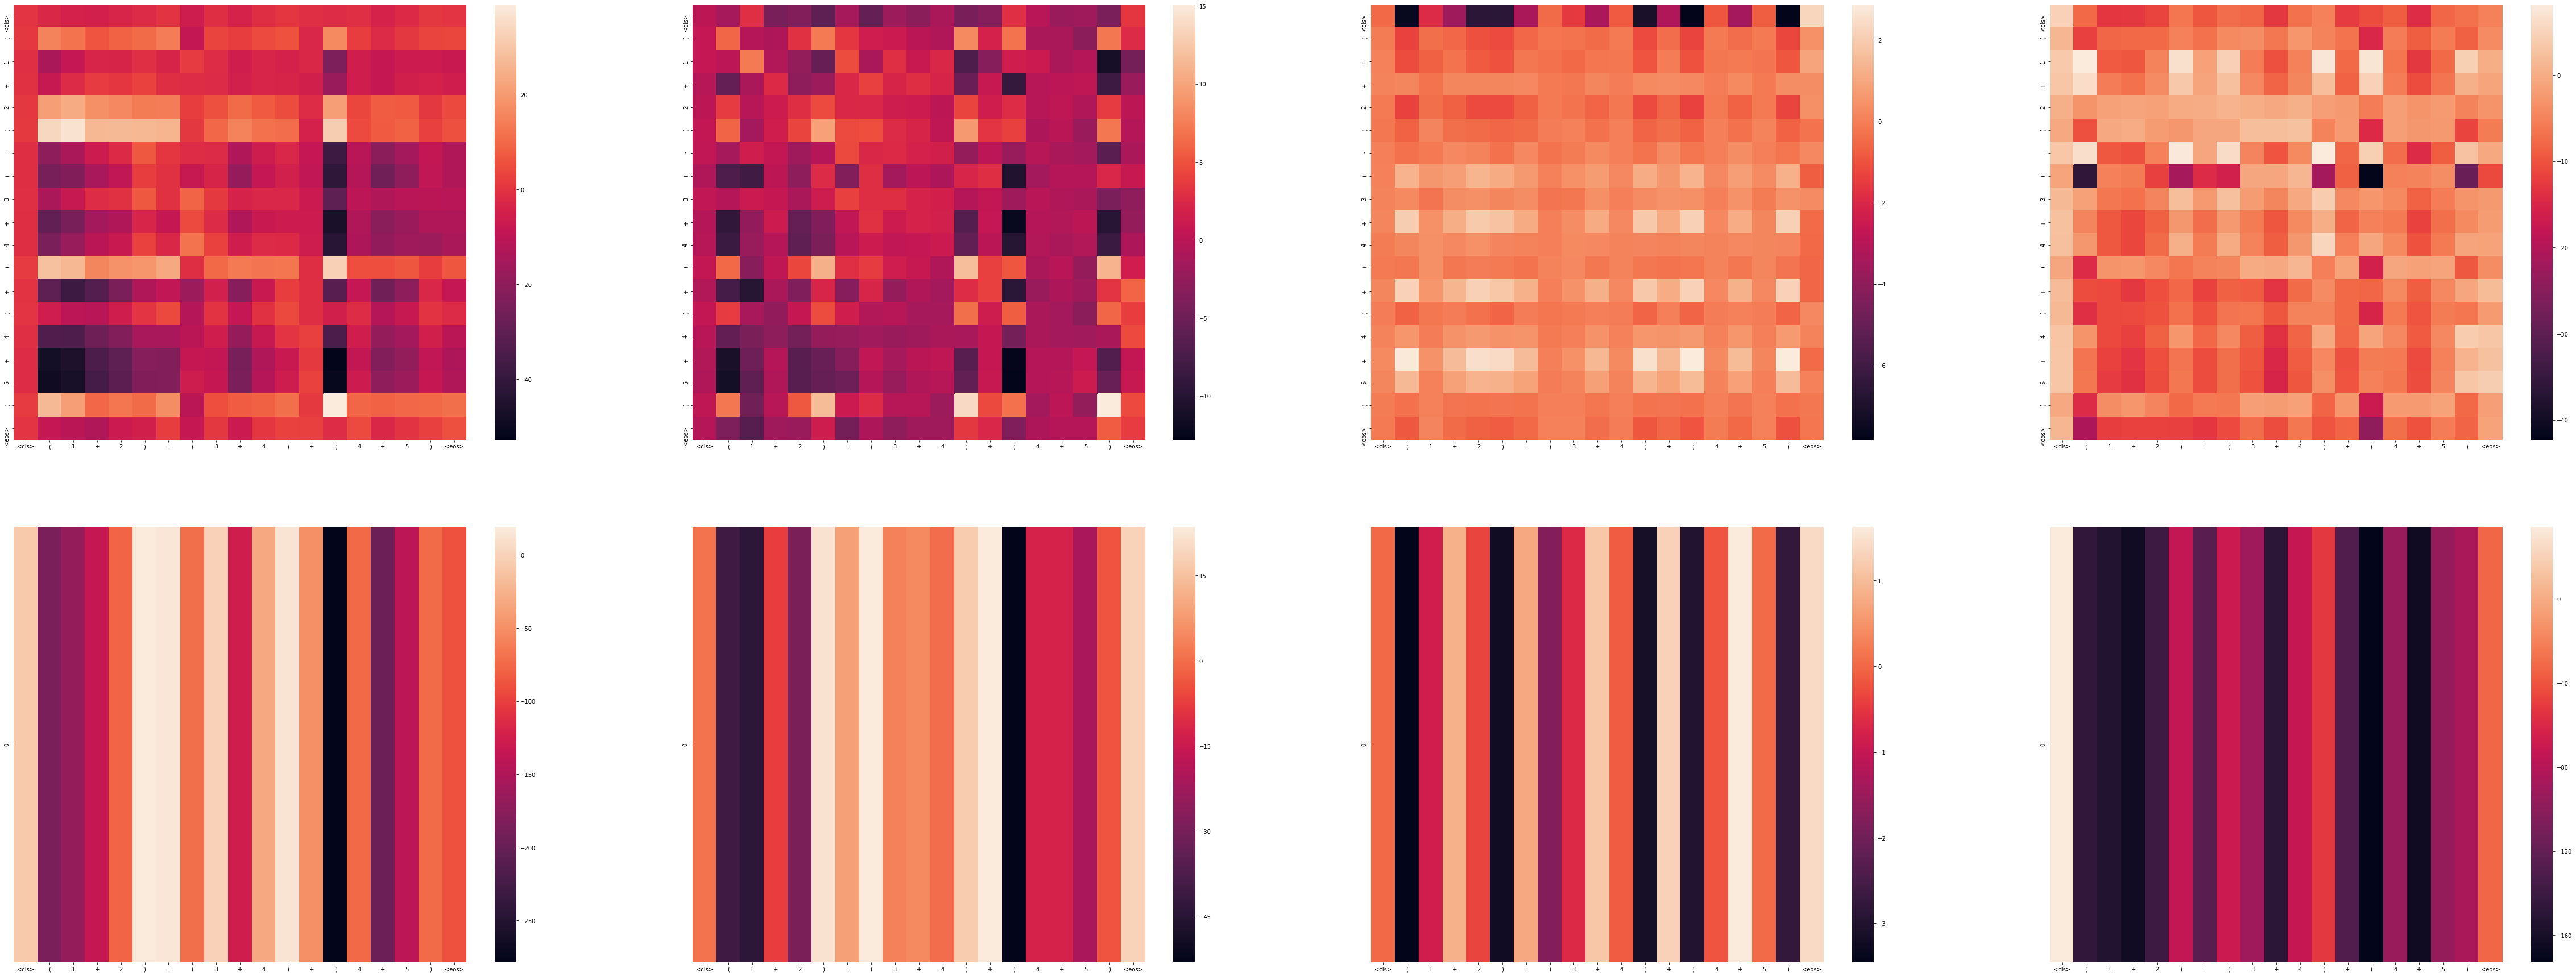

enc_utransformer_teacher/encode/UniversalTransformerEncoder/attention/_1_attention_bias
(1, 1, 1, 19)


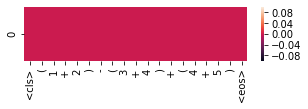

enc_utransformer_teacher/encode/UniversalTransformerEncoder/attention/_2_attention_logits
(1, 4, 19, 19)


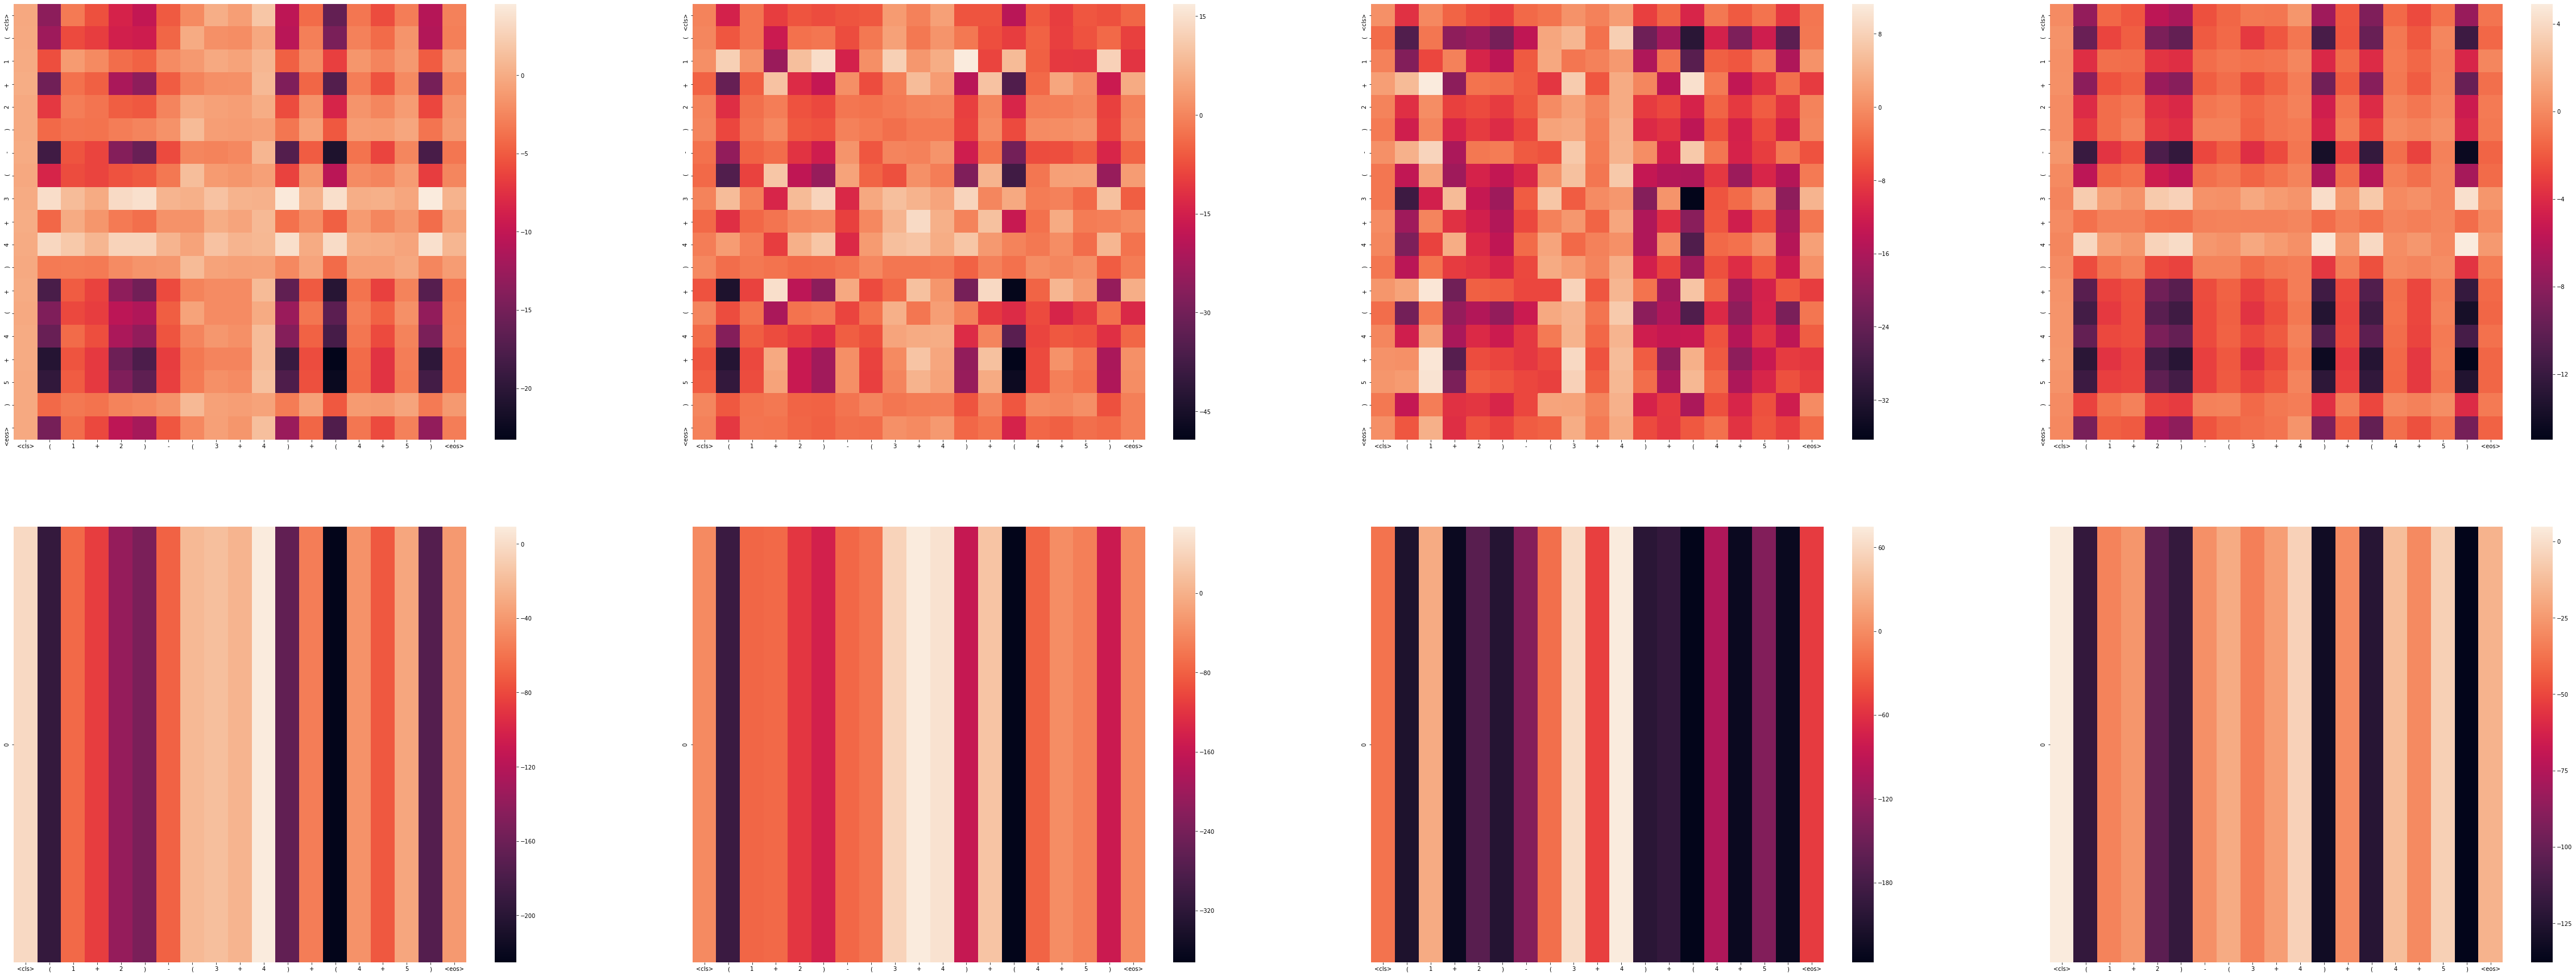

enc_utransformer_teacher/encode/UniversalTransformerEncoder/attention/_2_attention_bias
(1, 1, 1, 19)


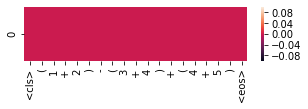

enc_utransformer_teacher/encode/UniversalTransformerEncoder/attention/_3_attention_logits
(1, 4, 19, 19)


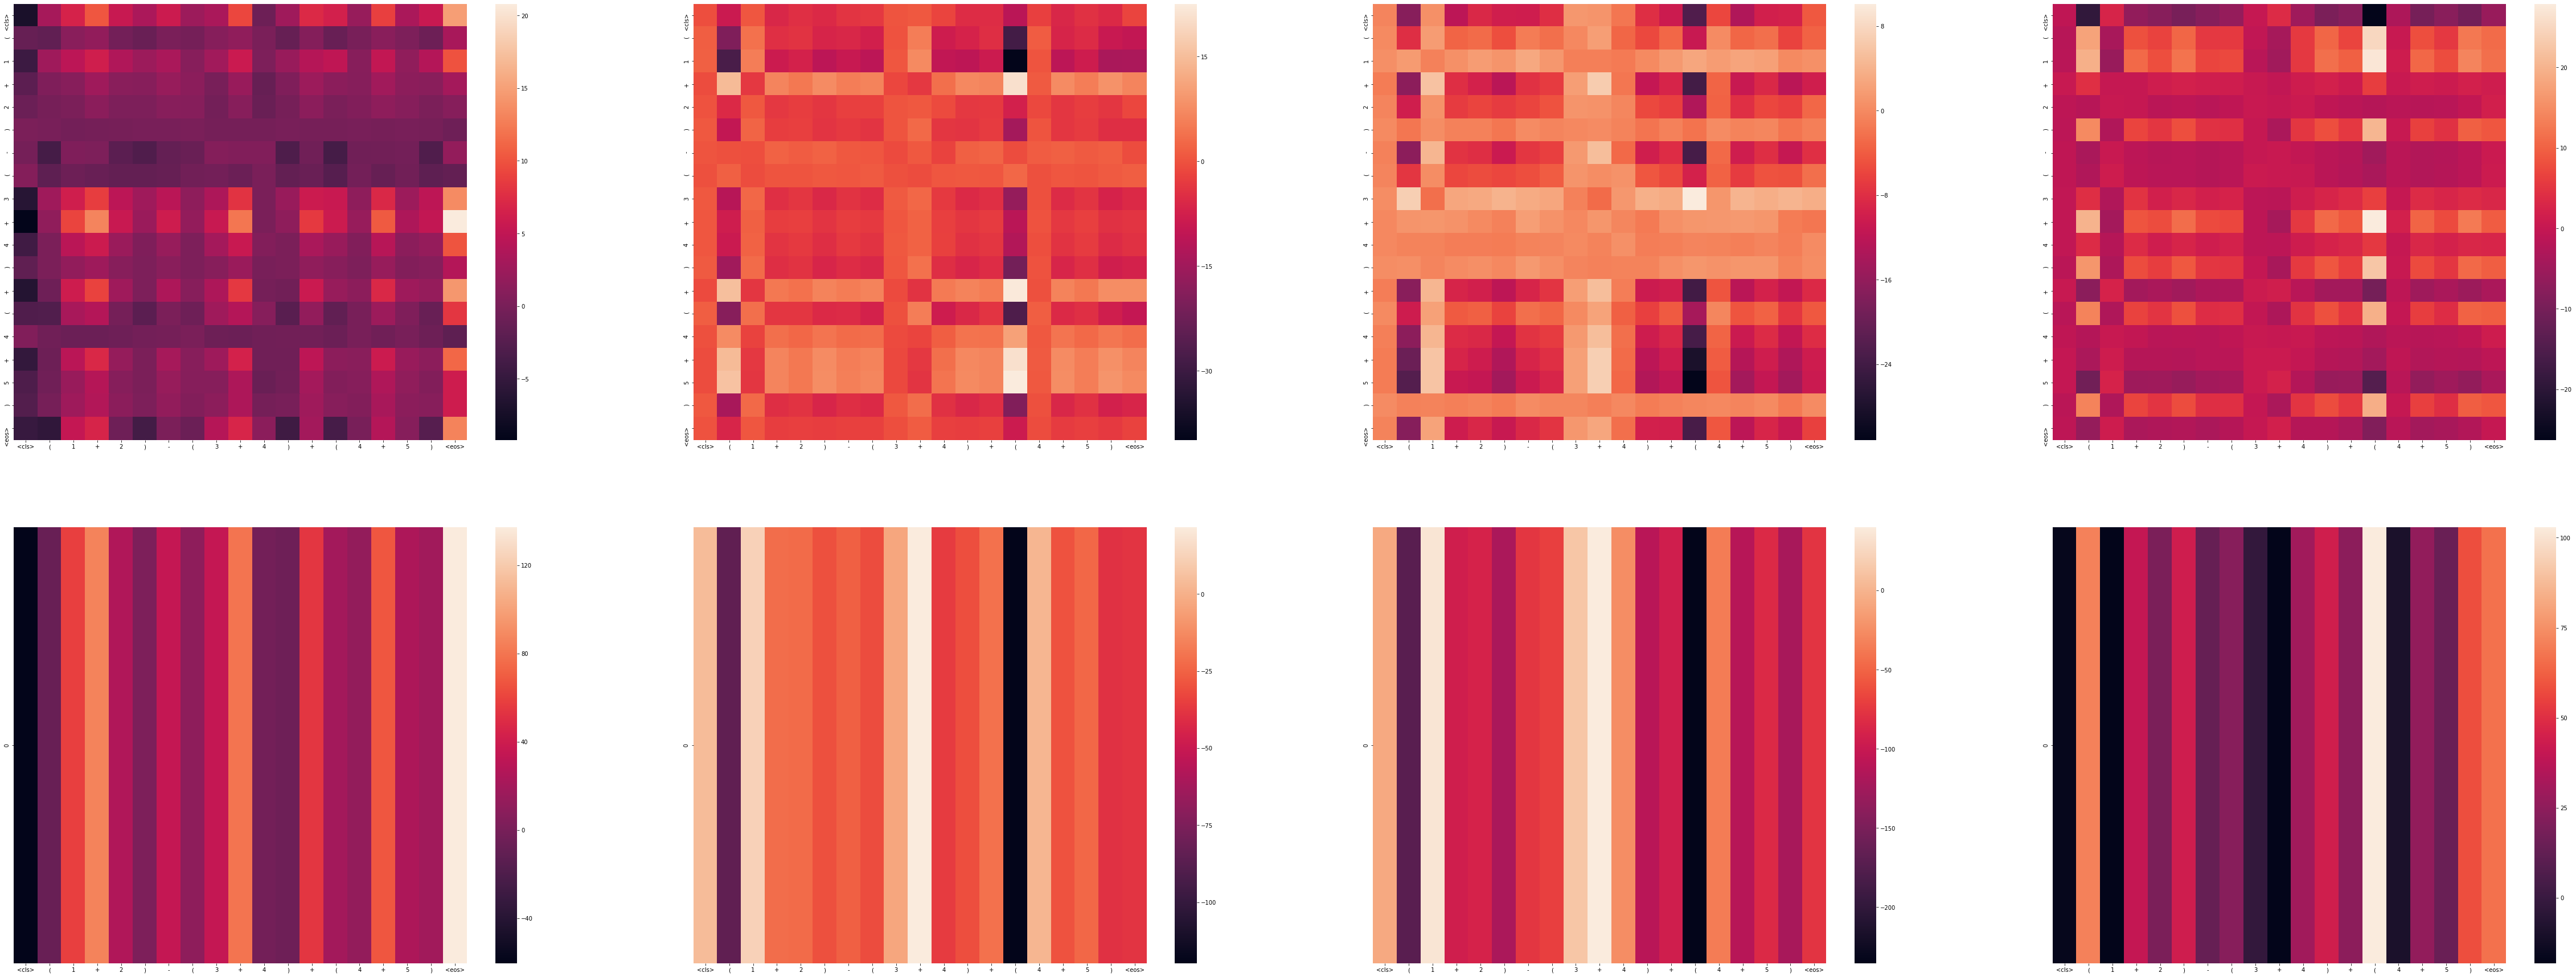

enc_utransformer_teacher/encode/UniversalTransformerEncoder/attention/_3_attention_bias
(1, 1, 1, 19)


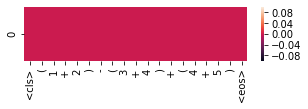

In [16]:
import seaborn as sb
number_of_heads = 4
item = 0

for key in weights_dic:
    print(key)
    print(weights_dic[key].numpy().shape)
    if weights_dic[key].numpy().shape[1] >=2:
        plt.figure(figsize=(82,31))
        axes_1 = {}
        axes_2 = {}
        for i in np.arange(number_of_heads):
            axes_1[i] = plt.subplot(2,4,i+1)
            g = sb.heatmap(weights_dic[key].numpy()[item][i], ax=axes_1[i])
            g.set(xticklabels=['<cls>']+example_input)
            g.set(yticklabels=['<cls>']+example_input)
            
            #print(np.sum(weights_dic[key].numpy()[item], axis=1))
            axes_2[i] = plt.subplot(2,4,4+i+1)
            g = sb.heatmap(np.sum(weights_dic[key].numpy()[item], axis=1)[i,None], ax=axes_2[i])
            g.set(xticklabels=['<cls>']+example_input)
    else:
        plt.figure(figsize=(5,1))
        g = sb.heatmap(weights_dic[key].numpy()[item][0])
        g.set(xticklabels=['<cls>']+example_input)

        
    plt.show()

In [108]:
teacher_train_examples, student_train_examples = train_iterator.get_next()
teacher_dev_examples, student_dev_examples = dev_iterator.get_next()

with tfe.restore_variables_on_create(checkpoint):
    train_output_dic = teacher_model.apply(teacher_train_examples, target_length=teacher_model.task.target_length, is_train=False)

INFO:tensorflow:inputs shape
INFO:tensorflow:tf.Tensor(
[[ 2 49 38 ... 42 50  1]
 [ 2 37 47 ...  0  0  0]
 [ 2 49 14 ...  0  0  0]
 ...
 [ 2 16 24 ...  0  0  0]
 [ 2 37 48 ...  0  0  0]
 [ 2 42 47 ...  0  0  0]], shape=(32, 53), dtype=int64)


In [109]:
np.argmax(train_output_dic['logits'], axis=-1) 

array([[23],
       [40],
       [23],
       [44],
       [15],
       [44],
       [38],
       [15],
       [15],
       [44],
       [23],
       [16],
       [15],
       [44],
       [35],
       [17],
       [44],
       [44],
       [44],
       [18],
       [23],
       [44],
       [23],
       [44],
       [17],
       [23],
       [17],
       [31],
       [23],
       [23],
       [44],
       [15]])

In [110]:
train_output_dic['targets'].numpy()

array([[14],
       [14],
       [22],
       [20],
       [42],
       [38],
       [37],
       [22],
       [11],
       [34],
       [17],
       [26],
       [46],
       [42],
       [33],
       [38],
       [40],
       [14],
       [45],
       [21],
       [17],
       [31],
       [42],
       [23],
       [43],
       [18],
       [46],
       [41],
       [31],
       [ 3],
       [40],
       [43]])

In [111]:
np.argmax(train_output_dic['logits'], axis=-1) == train_output_dic['targets'].numpy()

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False]])

In [112]:
import num2words
from word2number import w2n


examples_inputs = []
examples_targets = []
target_lens = []
input_lens = []
for i in student_model.task.id2word:
    example_input = [str(i),'<eos>']
    examples_inputs.append(teacher_model.task.encode(example_input))
    print(example_input)
    try:
        target = str(eval(example_input[0]))
    except:
        target = example_input[0]
        
    examples_targets.append(teacher_model.task.encode([target]))
    target_lens.append(1)
    input_lens.append(len(example_input))
    
print(examples_inputs)
print(examples_targets)
encoded_example = tf.convert_to_tensor(np.asarray(examples_inputs), dtype=tf.int64)
encoded_target = tf.convert_to_tensor(examples_targets, dtype=tf.int64)

example = (encoded_example, encoded_target, tf.convert_to_tensor(input_lens), tf.convert_to_tensor(target_lens))

weights_dic = {}
with tfe.restore_variables_on_create(checkpoint):
    teach_outputs = teacher_model.apply(example, target_length=teacher_model.task.target_length, is_train=False)
    student_outputs = student_model.apply(example, target_length=student_model.task.target_length, is_train=False)

['<pad>', '<eos>']
['<eos>', '<eos>']
['<cls>', '<eos>']
['-10', '<eos>']
['-9', '<eos>']
['-8', '<eos>']
['-7', '<eos>']
['-6', '<eos>']
['-5', '<eos>']
['-4', '<eos>']
['-3', '<eos>']
['-2', '<eos>']
['-1', '<eos>']
['0', '<eos>']
['1', '<eos>']
['2', '<eos>']
['3', '<eos>']
['4', '<eos>']
['5', '<eos>']
['6', '<eos>']
['7', '<eos>']
['8', '<eos>']
['9', '<eos>']
['10', '<eos>']
['+', '<eos>']
['-', '<eos>']
['minus ten', '<eos>']
['minus nine', '<eos>']
['minus eight', '<eos>']
['minus seven', '<eos>']
['minus six', '<eos>']
['minus five', '<eos>']
['minus four', '<eos>']
['minus three', '<eos>']
['minus two', '<eos>']
['minus one', '<eos>']
['zero', '<eos>']
['one', '<eos>']
['two', '<eos>']
['three', '<eos>']
['four', '<eos>']
['five', '<eos>']
['six', '<eos>']
['seven', '<eos>']
['eight', '<eos>']
['nine', '<eos>']
['ten', '<eos>']
['plus', '<eos>']
['minus', '<eos>']
['(', '<eos>']
[')', '<eos>']
[[0, 1], [1, 1], [2, 1], [3, 1], [4, 1], [5, 1], [6, 1], [7, 1], [8, 1], [9, 1], [1

In [113]:
list(zip(task.decode(np.argmax(student_outputs['logits'], axis=-1)[:,0]), task.decode(np.asarray(examples_targets)[:,0])))

[('4', '<pad>'),
 ('4', '<eos>'),
 ('4', '<cls>'),
 ('two', '-10'),
 ('four', '-9'),
 ('four', '-8'),
 ('4', '-7'),
 ('-6', '-6'),
 ('-4', '-5'),
 ('-4', '-4'),
 ('-10', '-3'),
 ('minus two', '-2'),
 ('minus two', '-1'),
 ('-10', '0'),
 ('minus five', '1'),
 ('two', '2'),
 ('four', '3'),
 ('4', '4'),
 ('four', '5'),
 ('four', '6'),
 ('10', '7'),
 ('eight', '8'),
 ('10', '9'),
 ('eight', '10'),
 ('4', '+'),
 ('4', '-'),
 ('two', 'minus ten'),
 ('four', 'minus nine'),
 ('four', 'minus eight'),
 ('4', 'minus seven'),
 ('-6', 'minus six'),
 ('-4', 'minus five'),
 ('-4', 'minus four'),
 ('-10', 'minus three'),
 ('minus two', 'minus two'),
 ('minus two', 'minus one'),
 ('-10', 'zero'),
 ('minus five', 'one'),
 ('two', 'two'),
 ('four', 'three'),
 ('4', 'four'),
 ('four', 'five'),
 ('four', 'six'),
 ('10', 'seven'),
 ('eight', 'eight'),
 ('10', 'nine'),
 ('eight', 'ten'),
 ('4', 'plus'),
 ('4', 'minus'),
 ('4', '('),
 ('4', ')')]

In [114]:
np.asarray(examples_targets)[:,0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

(51, 1, 256)


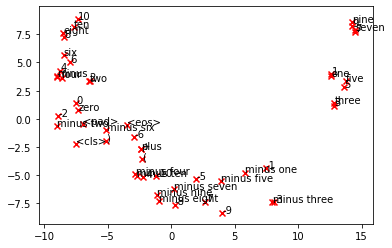

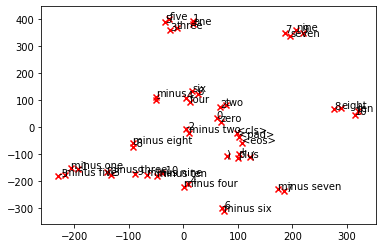

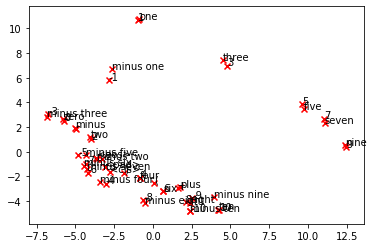

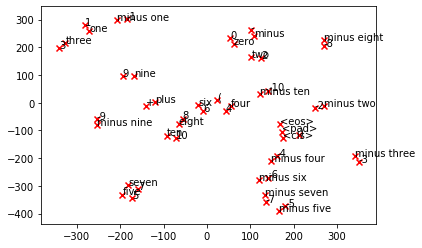

In [115]:
print(teach_outputs['outputs'].numpy().shape)

reps = teach_outputs['outputs'].numpy()[:,0,:]


points = reps
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(points)

tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=3)
tsne_emb = tsne.fit_transform(points)

M_reduced_plot_test = principalComponents
word2Ind_plot_test = student_model.task.word2id
words = student_model.task.id2word
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)

M_reduced_plot_test = tsne_emb
word2Ind_plot_test = student_model.task.word2id
words = student_model.task.id2word
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)



reps = student_outputs['outputs'].numpy()[:,0,:]


points = reps
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(points)

tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=4)
tsne_emb = tsne.fit_transform(points)

M_reduced_plot_test = principalComponents
word2Ind_plot_test = student_model.task.word2id
words = student_model.task.id2word
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)

M_reduced_plot_test = tsne_emb
word2Ind_plot_test = student_model.task.word2id
words = student_model.task.id2word
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)